In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

In [3]:
# Load your dataset (replace with your file name)
df = pd.read_csv("heart_attack_prediction_dataset.csv")

In [4]:
# Drop rows with missing values
df = df.dropna()

# Split "Blood Pressure" into two columns: Systolic and Diastolic
df[['Systolic_BP', 'Diastolic_BP']] = df['Blood Pressure'].str.split('/', expand=True)

# Convert these new columns to numeric types
df['Systolic_BP'] = pd.to_numeric(df['Systolic_BP'], errors='coerce')
df['Diastolic_BP'] = pd.to_numeric(df['Diastolic_BP'], errors='coerce')

# Drop the original "Blood Pressure" column
df = df.drop(columns=['Blood Pressure'])

# Drop rows where conversion to numeric failed (optional, to ensure clean data)
df = df.dropna()

In [5]:
# Define the features and target
feature_columns = [
    "Age", "Cholesterol", "Heart Rate", "Diabetes", "Family History",
    "Smoking", "Obesity", "Alcohol Consumption", "Exercise Hours Per Week",
    "Stress Level", "BMI", "Triglycerides", "Systolic_BP", "Diastolic_BP"
]  # Ensure these columns match your dataset
target_column = "Heart Attack Risk"  # Replace with the correct target column name if different

X = df[feature_columns]  # Features
y = df[target_column]    # Target

In [6]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
# Initialize Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [8]:
# Predict on the test set
y_pred = model.predict(X_test)

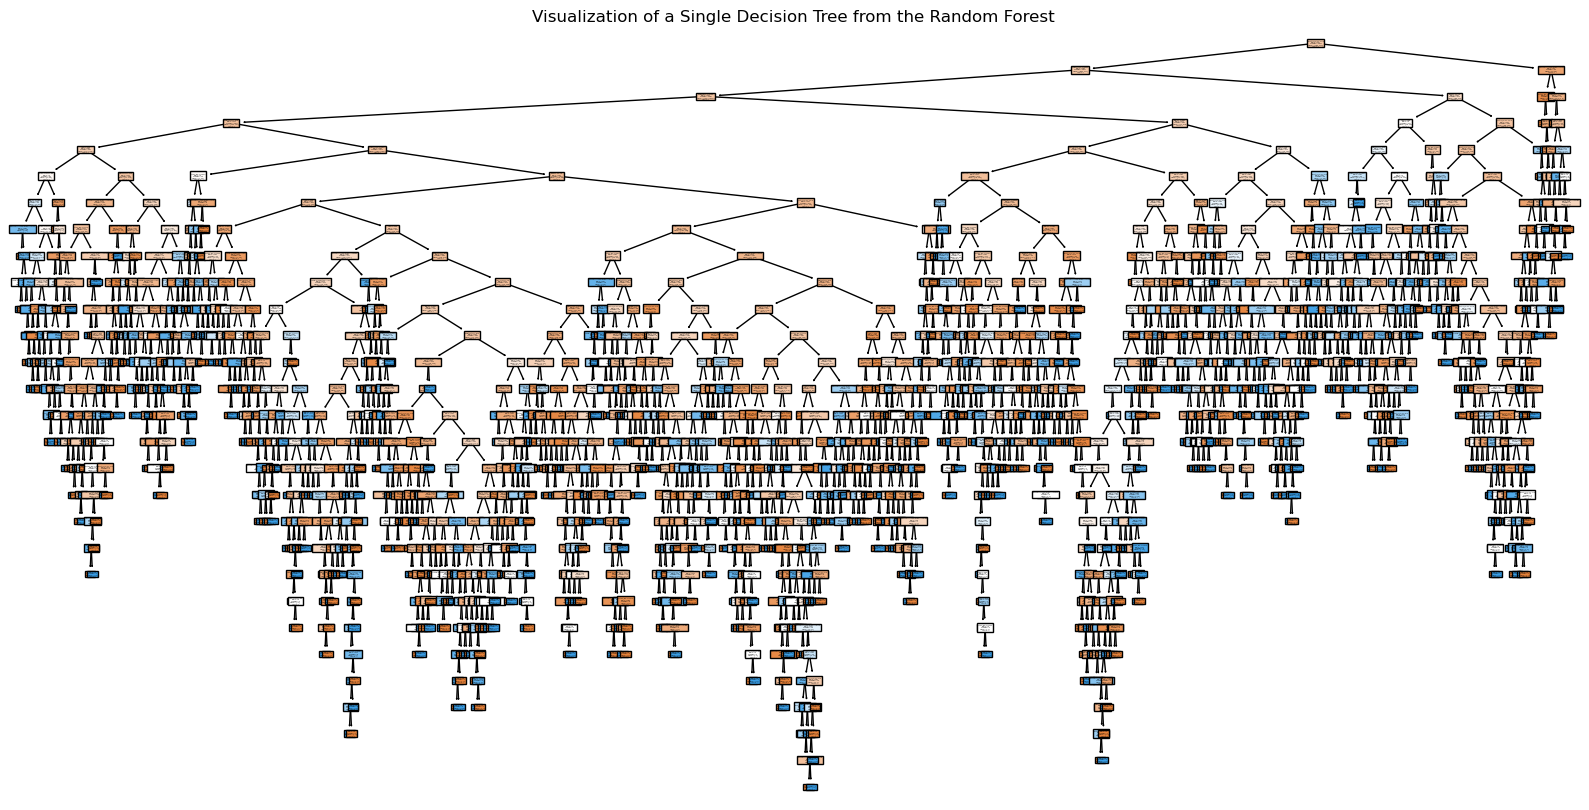

: 

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Convert class names to strings
class_names = [str(cls) for cls in model.classes_]

# Select the first tree from the Random Forest
tree = model.estimators_[0]

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=feature_columns, class_names=class_names, filled=True)
plt.title("Visualization of a Single Decision Tree from the Random Forest")
plt.show()


In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.63
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.97      0.77      1691
           1       0.38      0.04      0.07       938

    accuracy                           0.63      2629
   macro avg       0.51      0.50      0.42      2629
weighted avg       0.55      0.63      0.52      2629



In [ ]:
# Analyze feature importance
importances = model.feature_importances_
for feature, importance in zip(feature_columns, importances):
    print(f"{feature}: {importance:.2f}")

Age: 0.10
Cholesterol: 0.11
Heart Rate: 0.10
Diabetes: 0.02
Family History: 0.02
Smoking: 0.01
Obesity: 0.02
Alcohol Consumption: 0.02
Exercise Hours Per Week: 0.12
Stress Level: 0.06
BMI: 0.12
Triglycerides: 0.12
Systolic_BP: 0.10
Diastolic_BP: 0.09


In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verify the class distribution after resampling
from collections import Counter
print("Class distribution after SMOTE:", Counter(y_train_resampled))

Class distribution after SMOTE: Counter({0: 3933, 1: 3933})


In [ ]:
# Create a new Random Forest model with class weighting for additional balance
model = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)

# Retrain the model on the resampled data
model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [ ]:
# Make predictions on the test data
y_pred_resampled = model.predict(X_test)

# Evaluate the model's performance after addressing class imbalance
accuracy_resampled = accuracy_score(y_test, y_pred_resampled)
print(f"Accuracy after SMOTE: {accuracy_resampled:.2f}")
print("Classification Report after SMOTE:")
print(classification_report(y_test, y_pred_resampled))


Accuracy after SMOTE: 0.55
Classification Report after SMOTE:
              precision    recall  f1-score   support

           0       0.64      0.71      0.67      1691
           1       0.34      0.26      0.30       938

    accuracy                           0.55      2629
   macro avg       0.49      0.49      0.48      2629
weighted avg       0.53      0.55      0.54      2629



In [ ]:
# Get prediction probabilities
y_prob = model.predict_proba(X_test)[:, 1]

# Adjust the threshold (e.g., lower to 0.3 for better recall of the minority class)
import numpy as np

threshold = 0.8  # Adjust this value as needed
y_pred_adjusted = np.where(y_prob >= threshold, 1, 0)

# Evaluate performance with the adjusted threshold
accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted)
print(f"Accuracy with adjusted threshold: {accuracy_adjusted:.2f}")
print("Classification Report with adjusted threshold:")
print(classification_report(y_test, y_pred_adjusted))

Accuracy with adjusted threshold: 0.64
Classification Report with adjusted threshold:
              precision    recall  f1-score   support

           0       0.64      0.99      0.78      1691
           1       0.44      0.01      0.01       938

    accuracy                           0.64      2629
   macro avg       0.54      0.50      0.40      2629
weighted avg       0.57      0.64      0.51      2629



In [ ]:
# Get prediction probabilities
y_prob = model.predict_proba(X_test)[:, 1]

# Define a function to evaluate different thresholds
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_threshold(threshold):
    y_pred_adjusted = np.where(y_prob >= threshold, 1, 0)
    precision = precision_score(y_test, y_pred_adjusted, zero_division=0)
    recall = recall_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    print(f"Threshold: {threshold:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

# Try multiple thresholds
for threshold in np.arange(0.1, 1.0, 0.1):
    evaluate_threshold(threshold)


Threshold: 0.10, Precision: 0.36, Recall: 1.00, F1-Score: 0.53
Threshold: 0.20, Precision: 0.36, Recall: 1.00, F1-Score: 0.53
Threshold: 0.30, Precision: 0.36, Recall: 0.92, F1-Score: 0.51
Threshold: 0.40, Precision: 0.36, Recall: 0.64, F1-Score: 0.46
Threshold: 0.50, Precision: 0.34, Recall: 0.28, F1-Score: 0.31
Threshold: 0.60, Precision: 0.36, Recall: 0.11, F1-Score: 0.16
Threshold: 0.70, Precision: 0.30, Recall: 0.02, F1-Score: 0.04
Threshold: 0.80, Precision: 0.44, Recall: 0.01, F1-Score: 0.01
Threshold: 0.90, Precision: 0.00, Recall: 0.00, F1-Score: 0.00


In [ ]:
# Use the selected threshold (replace with the chosen value)
optimal_threshold = 0.3  # Example threshold
y_pred_final = np.where(y_prob >= optimal_threshold, 1, 0)

# Evaluate final model performance
from sklearn.metrics import accuracy_score, classification_report
accuracy_final = accuracy_score(y_test, y_pred_final)
print(f"Accuracy with threshold {optimal_threshold}: {accuracy_final:.2f}")
print(f"Classification Report with threshold {optimal_threshold}:")
print(classification_report(y_test, y_pred_final))


Accuracy with threshold 0.3: 0.38
Classification Report with threshold 0.3:
              precision    recall  f1-score   support

           0       0.65      0.06      0.12      1691
           1       0.36      0.94      0.52       938

    accuracy                           0.38      2629
   macro avg       0.50      0.50      0.32      2629
weighted avg       0.54      0.38      0.26      2629



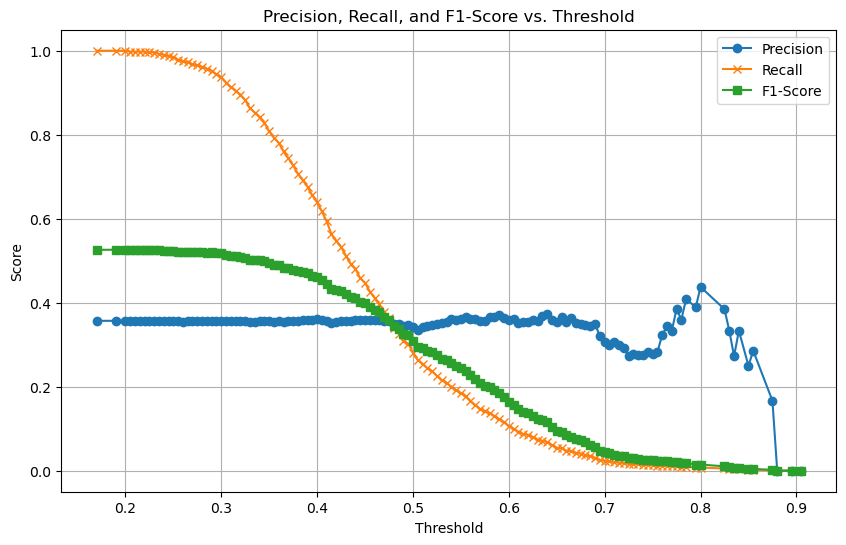

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Compute F1-scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Avoid division by zero

# Plot Precision, Recall, and F1-Score
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision', marker='o')
plt.plot(thresholds, recall[:-1], label='Recall', marker='x')
plt.plot(thresholds, f1_scores[:-1], label='F1-Score', marker='s')  # Add F1-Score
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score vs. Threshold')
plt.legend(loc='best')
plt.grid()
plt.show()


In [ ]:
# Set an optimal threshold (based on the trade-off observed)
optimal_threshold = 0.4  # Replace with the chosen threshold
y_pred_optimal = np.where(y_prob >= optimal_threshold, 1, 0)

# Evaluate performance with the optimal threshold
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)
print(f"Accuracy with threshold {optimal_threshold}: {accuracy_optimal:.2f}")
print(f"Classification Report with threshold {optimal_threshold}:")
print(classification_report(y_test, y_pred_optimal))

Accuracy with threshold 0.4: 0.47
Classification Report with threshold 0.4:
              precision    recall  f1-score   support

           0       0.65      0.37      0.47      1691
           1       0.36      0.64      0.46       938

    accuracy                           0.47      2629
   macro avg       0.51      0.51      0.47      2629
weighted avg       0.55      0.47      0.47      2629



###Notes
1. Dataset Characteristics
A key issue identified was that the "Blood Pressure" column contained values in a non-numeric format (e.g., '120/80'), which required splitting into two separate numeric features: systolic and diastolic blood pressure.

Some columns had missing or invalid data, which was handled by dropping rows with nulls during preprocessing.

The target class (Heart Attack Risk) is imbalanced, with more instances of one class (e.g., "no heart attack risk") than the other (e.g., "at risk").

2. Model Performance
Initially, a Random Forest Classifier was implemented with the default settings:

Accuracy: ~63%

Model primarily predicted the majority class, leading to poor recall for the minority class (heart attack risk), highlighting class imbalance as a major issue.

3. Addressing Class Imbalance
Applied SMOTE (Synthetic Minority Oversampling Technique) to balance the training dataset by creating synthetic samples for the minority class.

After retraining, the model's performance changed:

Accuracy after SMOTE: ~55%

Recall for the minority class improved, but precision dropped significantly, resulting in a moderate F1-score.

4. Decision Threshold Analysis
The default threshold (0.5) emphasized a trade-off between precision and recall, leading to low recall for the minority class.

Systematically experimenting with thresholds revealed:

Lower thresholds (e.g., 0.1-0.3): Achieved high recall but low precision.

Higher thresholds (e.g., 0.7-0.8): Boosted precision but drastically reduced recall.

The F1-score was highest at lower thresholds, indicating a recall-focused approach might be better for this dataset.